In [1]:
%matplotlib inline
import random
import hashlib
import base64
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import yaml

from sklearn.model_selection import train_test_split
from cycler import cycler

from functools import partial
from tqdm.notebook import tqdm
import simpy

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
current_dir = os.getcwd()
os.chdir("../src")
from dqnroute import *
from dqnroute.networks import *
os.chdir(current_dir)

In [4]:
def train_in_simulation(run_params, router_type, pkg_num,
                        training_router_type='link_state',
                        breaks_num=0, max_breaks=2, delta=20):
    period_len = pkg_num * delta
    max_pause = delta * max_breaks
    all_br_num = sum([breaks_num*cb for cb in range(1, max_breaks+1)])
    approx_total_time = period_len + (period_len + max_pause) * all_br_num
    
    with tqdm(total=approx_total_time) as bar:
        queue = DummyProgressbarQueue(bar)
        brain, loss_df, launch_df = run_training(
            NetworkRunner, run_params=run_params,
            router_type=router_type, training_router_type=training_router_type,
            pkg_num=5000, random_seed=42,
            progress_queue=queue, progress_step=20)
    return brain, loss_df, launch_df

def gen_episodes_progress(num_episodes, **kwargs):
    with tqdm(total=num_episodes) as bar:
        df = gen_episodes(bar=bar, num_episodes=num_episodes, **kwargs)
    return df

In [5]:
def shuffle(df):
    return df.reindex(np.random.permutation(df.index))

def find_first_sublist(seq, sublist, start=0):
    length = len(sublist)
    for index in range(start, len(seq)):
        if seq[index:index+length] == sublist:
            return index, index+length

def replace_sublist(seq, sublist, replacement):
    length = len(replacement)
    index = 0
    for start, end in iter(lambda: find_first_sublist(seq, sublist, index), None):
        seq[start:end] = replacement
        index = start + length
    return seq

def transform_to_one_out(df):
    old_cols = list(df.columns)
    neighbors_cols = [col for col in old_cols if col.startswith('neighbors')]
    target_cols = [col for col in old_cols if col.startswith('predict')]
    
    new_cols = replace_sublist(replace_sublist(old_cols, neighbors_cols, ['neighbour']),
                               target_cols, ['predict'])
    row_ix = 0
    nums = pd.Series(range(len(neighbors_cols)), index=neighbors_cols)
    new_rows_num = df[neighbors_cols].sum().sum()
    df_new = pd.DataFrame(columns=new_cols, index=np.arange(new_rows_num), dtype=np.float32)
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        nbrs = nums[row[neighbors_cols] != 0]
        preds = list(row[target_cols][row != -1000000])        
        new_row_tpl = row.drop(neighbors_cols + target_cols)
        
        for nbr, pred in zip(nbrs, preds):
            new_row = new_row_tpl
            new_row['neighbour'] = nbr
            new_row['predict'] = pred
            df_new.loc[row_ix] = new_row
            row_ix += 1
        
    return df_new.reindex(np.arange(len(df_new)))

In [6]:
def hash_graph(graph):
    if type(graph) != np.ndarray:
        graph = nx.to_numpy_matrix(graph, nodelist=sorted(graph.nodes))
    m = hashlib.sha256()
    m.update(graph.tobytes())
    return base64.b64encode(m.digest()).decode('utf-8')

class CachedEmbedding(Embedding):
    def __init__(self, InnerEmbedding, dim, **kwargs):
        self.dim = dim
        self.InnerEmbedding = InnerEmbedding
        self.inner_kwargs = kwargs
        self.fit_embeddings = {}
        
    def fit(self, graph, **kwargs):
        h = hash_graph(graph)
        if h not in self.fit_embeddings:
            embed = self.InnerEmbedding(dim=self.dim, **self.inner_kwargs)
            embed.fit(graph, **kwargs)
            self.fit_embeddings[h] = embed
    
    def transform(self, graph, idx):
        h = hash_graph(graph)
        return self.fit_embeddings[h].transform(idx)

In [7]:
def one_or_emb(vals, embedding=None):
    if embedding is None:
        return vals
    return embedding.get_embedding(vals.astype(int))

def add_inp_cols(tag, dim):
    if dim > 1:
        return mk_num_list(tag + '_', dim)
    else:
        return tag

def qnetwork_batches(net, data, batch_size=64, embedding=None):
    n = net.graph_size
    data_cols = []
    amatrix_cols = get_amatrix_cols(n)
    
    for (tag, dim) in net.add_inputs:
        if tag == 'amatrix':
            data_cols.append(amatrix_cols)
        else:
            data_cols.append(add_inp_cols(tag, dim))

    for (a, b) in make_batches(data.shape[0], batch_size):
        batch = data[a:b]
        addr = batch['addr'].values
        dst = batch['dst'].values
        nbr = batch['neighbour'].values
        
        if embedding is not None:
            amatrices = batch[amatrix_cols].values
            new_btch = []
            for (addr_, dst_, nbr_, A) in zip(addr, dst, nbr, amatrices):
                A = A.reshape(n, n)
                embedding.fit(A)
                new_addr = embedding.transform(A, int(addr_))
                new_dst = embedding.transform(A, int(dst_))
                new_nbr = embedding.transform(A, int(nbr_))
                new_btch.append((new_addr, new_dst, new_nbr))
                
            [addr, dst, nbr] = stack_batch(new_btch)
            
        addr_inp = torch.tensor(addr, dtype=torch.float)
        dst_inp = torch.tensor(dst, dtype=torch.float)
        nbr_inp = torch.tensor(nbr, dtype=torch.float)
                
        inputs = tuple(torch.tensor(batch[cols].values, dtype=torch.float)
                       for cols in data_cols)
        output = torch.tensor(batch['predict'].values, dtype=torch.float)
        
        yield ((addr_inp, dst_inp, nbr_inp) + inputs, output)

def qnetwork_pretrain_epoch(net, optimizer, data, **kwargs):
    loss_func = nn.MSELoss()
    for (batch, target) in qnetwork_batches(net, data, **kwargs):
        optimizer.zero_grad()
        output = net(*batch)
        loss = loss_func(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()
        yield float(loss)
        
def qnetwork_pretrain(net, data, optimizer='rmsprop', epochs=1,
                      save_net=True, **kwargs):
    optimizer = get_optimizer(optimizer)(net.parameters())
    epochs_losses = []
    
    for i in tqdm(range(epochs)):
        sum_loss = 0
        loss_cnt = 0
        for loss in tqdm(qnetwork_pretrain_epoch(net, optimizer, data, **kwargs),
                                  desc='epoch {}'.format(i)):
            sum_loss += loss
            loss_cnt += 1
        epochs_losses.append(sum_loss / loss_cnt)
        
    if save_net:
        net.save()
    
    return epochs_losses

In [8]:
def save_losses(losses_dict, path):
    df = pd.DataFrame(losses_dict)
    df.to_csv(path, index=False)

def load_losses(path):
    df = pd.read_csv(path, index_col=False)
    return df.to_dict(orient='list')

def plot_losses(losses_dict, from_epoch=0, num_epochs=None, xlim=None, ylim=None,
                fsize=16, figsize=(13, 3), title=None, save_path=None):
    if num_epochs is None:
        num_epochs = len(next(iter(losses_dict.values())))
        
    fig = plt.figure(figsize=figsize)
    
    x = range(from_epoch+1, num_epochs+1)
    for (label, losses) in losses_dict.items():
        plt.plot(x, losses[from_epoch:num_epochs], label=label)
    plt.legend(prop={'size': fsize})
    plt.xlabel('Epoch', fontsize=fsize)
    plt.xticks(x)
    plt.grid()
    plt.ylabel('MSE', fontsize=fsize)
    
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if title is not None:
        plt.title(title, fontsize=fsize)
        
    plt.show(fig)
    if save_path is not None:
        fig.savefig('../img/' + save_path, bbox_inches='tight')

In [63]:
#scenario, emd_dim, graph_size = '../launches/igor/acyclic_conveyor_energy_test.yaml', 10, 20
#scenario, emb_dim, graph_size = '../launches/igor/conveyor_cyclic_energy_test.yaml', 5, 8
#scenario, emb_dim, graph_size = '../launches/igor/conveyor_cyclic2_energy_test.yaml', 6, 16
#scenario, emb_dim, graph_size = '../launches/igor/tarau2010.yaml', 8, 27
scenario, emb_dim, graph_sizeph_size = '../launches/igor/johnstone2010.yaml', 12, 54

data_conv = gen_episodes_progress(ignore_saved=True,
    context='conveyors', num_episodes=10000, random_seed=42,
    run_params=scenario,
    save_path='../logs/data_conveyor1_oneinp_new.csv')

In [64]:
data_conv.loc[:, 'working'] = 1.0
data_conv.head()

,addr,dst,neighbour,amatrix_0_0,amatrix_0_1,amatrix_0_2,amatrix_0_3,amatrix_0_4,amatrix_0_5,amatrix_0_6,...,amatrix_53_46,amatrix_53_47,amatrix_53_48,amatrix_53_49,amatrix_53_50,amatrix_53_51,amatrix_53_52,amatrix_53_53,predict,working
0,7.0,40.0,8.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-305.0,1.0
1,7.0,40.0,33.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-465.0,1.0
2,52.0,1.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-130.0,1.0
3,15.0,17.0,16.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-370.0,1.0
4,8.0,14.0,25.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-530.0,1.0


In [65]:
conv_emb = CachedEmbedding(LaplacianEigenmap, dim=emb_dim)

In [66]:
conveyor_network_ng_emb = QNetwork(graph_size, scope='conveyor_test_ng', activation='relu',
                                   layers=[64, 64], embedding_dim=conv_emb.dim)
conveyor_network_ng_emb_ws = QNetwork(graph_size, scope='conveyor_test_ng', activation='relu',
                                      layers=[64, 64], additional_inputs=[{'tag': 'working', 'dim': 1}],
                                      embedding_dim=conv_emb.dim)

In [67]:
conveyor_network_ng_emb_losses = qnetwork_pretrain(conveyor_network_ng_emb, shuffle(data_conv), epochs=10,
                                                   embedding=conv_emb)

In [68]:
conveyor_network_ng_emb_ws_losses = qnetwork_pretrain(conveyor_network_ng_emb_ws, shuffle(data_conv), epochs=20,
                                                      embedding=conv_emb)

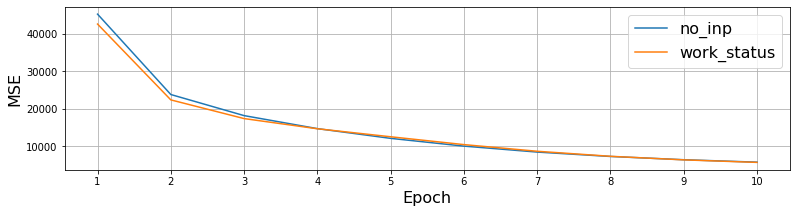

In [69]:
plot_losses({
    'no_inp': conveyor_network_ng_emb_losses,
    'work_status': conveyor_network_ng_emb_ws_losses,
})